   <h1>       A project on making movie database from scrapping wikipedia</h1>

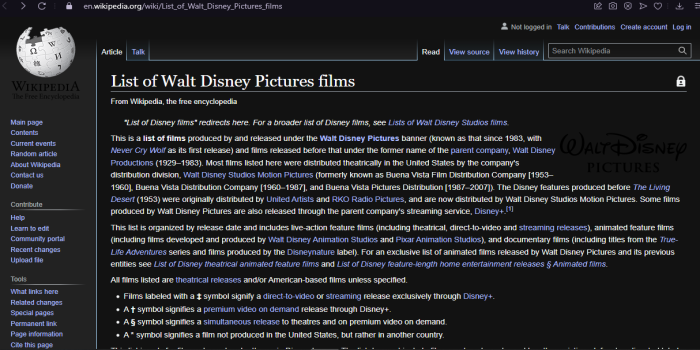

In [1]:
from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films").text
source = BeautifulSoup(response, 'lxml')
source.prettify()[:1000] # print the grabbed html as string

'<!DOCTYPE html>\n<html class="client-nojs" dir="ltr" lang="en">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   List of Walt Disney Pictures films - Wikipedia\n  </title>\n  <script>\n   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"e09dbd4e-c7f1-4db0-8825-7c454c8c02c7","wgCSPNonce":false,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_Walt_Disney_Pictures_films","wgTitle":"List of Walt Disney Pictures films","wgCurRevisionId":1089071790,"wgRevisionId":1089071790,"wgArticleId":1970335,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Webarchive template wayback links","CS1 maint: url-status","Art

# first we need to get all the links of movie pages from the table 

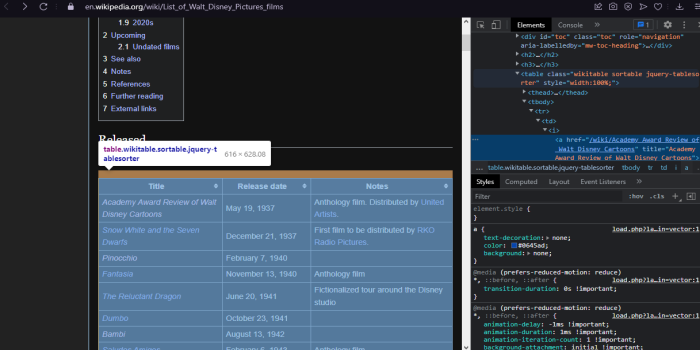

In [3]:
movie_paths = []
tables = source.find_all("table", class_="wikitable sortable") # to grab all the tables

index = 0
for table in tables:
    rows = table.find_all("tr") # to grab all the rows available in the tables

    for row in rows:
        if row.find('td') and row.td.a: # to grab only the first column in tables to make sure to only grab the movies links
                                        # and only take links if there are any a tags
            path = row.td.find('a').get('href')
            new_path = "https://en.wikipedia.org/" + path
            movie_paths.append(new_path)
                
            index +=  1
            if index % 50 == 0: # to keep track of for loop
                print(new_path)
                

https://en.wikipedia.org//wiki/Jungle_Cat_(film)
https://en.wikipedia.org//wiki/The_Wild_Country
https://en.wikipedia.org//wiki/The_Devil_and_Max_Devlin
https://en.wikipedia.org//wiki/Heavyweights
https://en.wikipedia.org//wiki/Recess:_School%27s_Out
https://en.wikipedia.org//wiki/The_Pacifier
https://en.wikipedia.org//wiki/Jonas_Brothers:_The_3D_Concert_Experience
https://en.wikipedia.org//wiki/Oz_the_Great_and_Powerful
https://en.wikipedia.org//wiki/Ralph_Breaks_the_Internet
https://en.wikipedia.org//wiki/Pinocchio_(2022_live-action_film)
https://en.wikipedia.org//wiki/Suzi_Yoonessi


<h1>Now lets take one movie page to get the datas </h1>

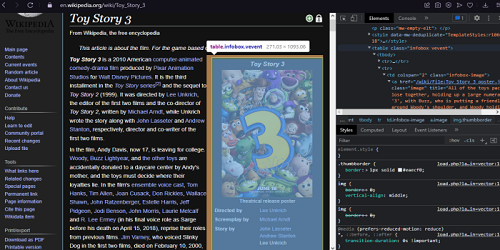


In [6]:
# to remove references from the html
def remove_tags(html):
    # converting html from bs4 class to string
    soup = str(html)
    # parse html content
    soup = BeautifulSoup(soup, "html.parser")

    for data in soup(['sup', 'span']):
        # Remove tags
        data.decompose()
    
    return soup

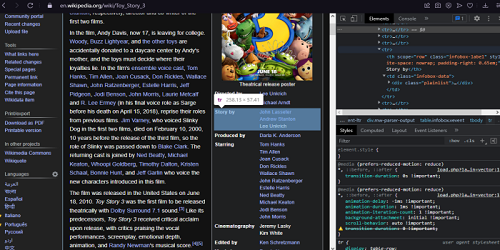

In [7]:
# to get label text from the label cell
def get_label(row_label):
    li = row_label.text.split("\n")
    if len(li) == 1:
        return li[0]
    
    return " ".join(li).strip()

# to get the datas from the data cell
def get_data(row_data):
#     checking different cases to get the data for different cases
    if row_data.find_all("li"):
        datas = [data.text.replace("\xa0", " ").strip() for data in row_data.find_all('li')] # to replace \xa0 from dollars
        if len(datas) == 1:
            return datas[0]
        return datas
# second case to consider   
    elif row_data.find('br'):
        datas = str(row_data).split('br')
        text_values = []
        for data in datas:
            soup = BeautifulSoup(data, 'lxml')
            text_values.append(soup.text.replace('/>', ''))
        return text_values

    
    return row_data.text.replace('\xa0', " ").strip()


def get_table_datas(movie):
    info_box = {}
    response = requests.get(movie).text
    source = BeautifulSoup(response, 'lxml')
    info_rows = source.find("table", class_="infobox vevent").find_all("tr") # to select info table box and grab all the rows
    
    for index, row in enumerate(info_rows):

        if index == 0:
            info_box["Title"] = row.text # if it index is 0 then we do not need grab any columns and just the text would do
            continue
        if index == 1:
            continue                     # if the index is 1 the row would be the picture and we would want to drop it
            

        row_label = row.th               # to grab the first column containing the labels
        row_data = row.td                # to grab the second column containing all datas relating to the labels
        if row_label and row_data:
            parsed_row_data = remove_tags(row_data) # to remove any sup or span tags
            label_value = get_label(row_label)      # to get the label from the label cell
            data_value = get_data(parsed_row_data)  # to get corospending labels datas 
            info_box[label_value] = data_value      # assigning the label to datas

    return info_box

In [8]:
get_table_datas('https://en.wikipedia.org/wiki/Toy_Story')

{'Title': 'Toy Story',
 'Directed by': 'John Lasseter',
 'Screenplay by': ['Joss Whedon',
  'Andrew Stanton',
  'Joel Cohen',
  'Alec Sokolow'],
 'Story by': ['John Lasseter', 'Pete Docter', 'Andrew Stanton', 'Joe Ranft'],
 'Produced by': ['Bonnie Arnold', 'Ralph Guggenheim'],
 'Starring': ['Tom Hanks',
  'Tim Allen',
  'Don Rickles',
  'Jim Varney',
  'Wallace Shawn',
  'John Ratzenberger',
  'Annie Potts',
  'John Morris',
  'Erik von Detten'],
 'Edited by': ['Robert Gordon', 'Lee Unkrich'],
 'Music by': 'Randy Newman',
 'Productioncompanies': ['Walt Disney Pictures', 'Pixar Animation Studios'],
 'Distributed by': 'Buena Vista Pictures Distribution',
 'Release dates': ['November 19, 1995 (El Capitan Theatre)',
  'November 22, 1995 (United States)'],
 'Running time': '81 minutes',
 'Country': 'United States',
 'Language': 'English',
 'Budget': '$30 million',
 'Box office': '$363 million'}

In [9]:
import time

movie_datas = []

for index, movie in enumerate(movie_paths):
    try:
        info = get_table_datas(movie)
        movie_datas.append(info)
        if index % 50 == 0:
            print(index, movie)
    except:
        print(index)
        continue
        
    time.sleep(2) # to not make continous request

0 https://en.wikipedia.org//wiki/Academy_Award_Review_of_Walt_Disney_Cartoons
50 https://en.wikipedia.org//wiki/Ten_Who_Dared
100 https://en.wikipedia.org//wiki/The_Aristocats
150 https://en.wikipedia.org//wiki/Amy_(1981_film)
200 https://en.wikipedia.org//wiki/Man_of_the_House_(1995_film)
250 https://en.wikipedia.org//wiki/Lady_and_the_Tramp_II:_Scamp%27s_Adventure
300 https://en.wikipedia.org//wiki/Ice_Princess
350 https://en.wikipedia.org//wiki/Race_to_Witch_Mountain
400 https://en.wikipedia.org//wiki/Wings_of_Life
450 https://en.wikipedia.org//wiki/Mary_Poppins_Returns
498
500 https://en.wikipedia.org//wiki/Disenchanted_(film)
506
516
518
526
531
533
535
538
540
541
547
548
549
550 https://en.wikipedia.org//wiki/The_Jungle_Book_(2016_film)#Sequel
552


In [10]:
# we were able to get most the movie datas
print(len(movie_paths), len(movie_datas))

553 538


In [11]:
# lets save the movie_datas as a json file
import json

with open("./movie_datas/movie_datas.json", "w", encoding='utf-8') as file:
    json.dump(movie_datas, file, ensure_ascii=False, indent=2)

In [6]:
import json

with open("./movie_datas/movie_datas.json", "r", encoding='utf-8') as file:
    movie_datas = json.load(file)
len(movie_datas)

538

In [7]:
movie_datas[0]

{'Title': 'Academy Award Review of Walt Disney Cartoons',
 'Productioncompany': 'Walt Disney Productions',
 'Distributed by': 'United Artists',
 'Release date': 'May 19, 1937',
 'Running time': '41 minutes (74 minutes 1966 release)',
 'Country': 'United States',
 'Language': 'English',
 'Box office': '$45.472'}

<h1>Lets change the running time to miute</h1>


In [8]:
for index, movie in enumerate(movie_datas):
    run_time = movie.get("Running time", 'N/A')
    if type(run_time) == list:
        run_time = run_time[0]
    time = run_time.split()[0].split("–")[0]
    movie.pop('Running time', None)
    movie["Running Time(min)"] = time
    
    if index % 50 == 0:
        print(time)

41
92
79
97
96
69
97
98
77
131
58


In [9]:
movie_datas[0]

{'Title': 'Academy Award Review of Walt Disney Cartoons',
 'Productioncompany': 'Walt Disney Productions',
 'Distributed by': 'United Artists',
 'Release date': 'May 19, 1937',
 'Country': 'United States',
 'Language': 'English',
 'Box office': '$45.472',
 'Running Time(min)': '41'}

<h1>changing the budget and box office values to floating point number in dollar using REGULAR EXPRESSION</h1>

In [10]:
import re
pattern = re.compile(r'\$([\d,.-]*)\w*(\s? million)?')

def get_box_office_value(movie):
    box_office = movie.get("Box office") # getting only the box offile key value to search for the pattern
    
    if box_office:
        box_office_text = str(box_office) # converting the box office value to string
        match = pattern.search(box_office_text) # searching the text for patterns
        
        if match: 
            value = match.group()[1:].split()[0]  # getting only dolllar value and checking different edge cases
            if ',' in value:
                new_box_office = value.replace(',', '')
                return float(new_box_office)
            if "million" in box_office_text:
                value = match.group()[1:].split('million')[0].strip()
                new_box_office = float(value) * 1000000
                return new_box_office
            elif 'billion' in box_office_text:
                value = match.group()[1:].split('billion')[0].strip()
                new_box_office = float(value) * 1000000 * 1000
                return new_box_office
            
    return 'N/A'


def get_budget_value(movie):
    budget = movie.get("Budget") 
    
    if budget:
        budget_text = str(budget)           # converting to string if Budget exits
        match = pattern.search(budget_text)
        
        if match:
            value = match.group()[1:].split()[0] # getting only the dollar values and checking all the cases
            if ',' in value:
                new_budget = value.replace(',', '')
                return float(new_budget)
            
            if "million" in budget_text:
                value = match.group()[1:].split('million')[0].strip()
                if '-' in value:
                    get_budget = float(value.split('-')[0]) * 1000000
                    return get_budget
                new_budget = float(value) * 1000000
                return new_budget
            elif 'billion' in budget_text:
                value = match.group()[1:].split('billion')[0].strip()
                new_budget = float(value) * 1000000 * 1000
                return new_budget
            
    return 'N/A'

print(get_box_office_value(movie_datas[1]))

418000000.0


In [11]:
# passing the function to all the movie info
for movie in movie_datas:
    movie['Budget($)'] = get_budget_value(movie)
    movie["Box office($)"] = get_box_office_value(movie)
    movie.pop('Budget', None)
    movie.pop("Box office", None)

In [12]:
print([movie.get('Box office($)') for movie in movie_datas][:30])

values = [movie.get('Box office($)') for movie in movie_datas]
count = 0
for value in values:
    if value == 'N/A':
        count += 1
print("The number of N/A values ", count)
print("The number of float values found", len(movie_datas) - count)

['N/A', 418000000.0, 164000000.0, 76400000.0, 960000.0, 1300000.0, 267399999.99999997, 1135000.0, 799000.0, 3355000.0, 3275000.0, 65000000.0, 3165000.0, 2560000.0, 3700000.0, 1625000.0, 182000000.0, 4100000.0, 2400000.0, 2100000.0, 87400000.0, 1000000.0, 2600000.0, 'N/A', 1750000.0, 28200000.0, 2150000.0, 187000000.0, 2100000.0, 1600000.0]
The number of N/A values  136
The number of float values found 402


In [13]:
movie_datas[0]

{'Title': 'Academy Award Review of Walt Disney Cartoons',
 'Productioncompany': 'Walt Disney Productions',
 'Distributed by': 'United Artists',
 'Release date': 'May 19, 1937',
 'Country': 'United States',
 'Language': 'English',
 'Running Time(min)': '41',
 'Budget($)': 'N/A',
 'Box office($)': 'N/A'}

<h1>changing the dates to datetime module</h1>

In [14]:
from datetime import datetime

def get_date(movie):
    date_text = movie.get("Release date")
    formats = ["%B %d %Y", "%B %d, %Y", "%d %B %Y", "%Y", "%B %Y"]
    
    if date_text:
        str_date = date_text.split("(")[0].strip()
        
        if "–" in str_date:
            str_date = str_date.split("–")[0].strip()
        
        for fmt in formats: # trying out different formats and converting it to date time 
            try:
                return datetime.strptime(str_date, fmt).date()
            except ValueError:
                pass
        
    return "N/A"

In [15]:
get_date(movie_datas[0])

datetime.date(1937, 5, 19)

In [16]:
# passing all the movies
for movie in movie_datas:
    new_date = get_date(movie)
    movie.pop("Release date", None)
    movie["Release date"] = new_date

In [17]:
print([movie.get("Release date") for movie in movie_datas][:30])

count = 0

for value in values:
    if value == "N/A":
        count += 1
        
print("The number of null values: ", count)
print("The number of datetimes found", len(movie_datas)-count)

[datetime.date(1937, 5, 19), 'N/A', 'N/A', datetime.date(1940, 11, 13), datetime.date(1941, 6, 27), 'N/A', 'N/A', 'N/A', datetime.date(1943, 7, 17), 'N/A', 'N/A', 'N/A', datetime.date(1947, 9, 27), datetime.date(1948, 5, 27), 'N/A', datetime.date(1949, 10, 5), 'N/A', 'N/A', 'N/A', 'N/A', datetime.date(1953, 2, 5), datetime.date(1953, 7, 23), datetime.date(1953, 11, 10), 'N/A', datetime.date(1954, 8, 17), datetime.date(1954, 12, 23), datetime.date(1955, 5, 25), datetime.date(1955, 6, 22), datetime.date(1955, 9, 14), datetime.date(1955, 12, 22)]
The number of null values:  136
The number of datetimes found 402


In [18]:
movie_datas[0]

{'Title': 'Academy Award Review of Walt Disney Cartoons',
 'Productioncompany': 'Walt Disney Productions',
 'Distributed by': 'United Artists',
 'Country': 'United States',
 'Language': 'English',
 'Running Time(min)': '41',
 'Budget($)': 'N/A',
 'Box office($)': 'N/A',
 'Release date': datetime.date(1937, 5, 19)}

<h1>In the datas there are two values one Release date and other Release dates if one is present other is absent. so we have to take the value Release dates and paste it to the N/A value of Release date </h1>

In [19]:
from datetime import datetime

def get_release_dates(movie):
    date_text = movie.get("Release dates")

    formats = ["%B %d %Y", "%B %d, %Y", "%d %B %Y", "%Y", "%B %Y"]
    if date_text:
        str_date = date_text[0].split("(")[0].strip()
        
        if "–" in str_date:
            str_date = str_date.split("–")[0].strip()
        
        for fmt in formats:
            try:
                return datetime.strptime(str_date, fmt).date()
            except ValueError:
                pass
        
    return "N/A"


In [20]:
for movie in movie_datas:
    new_release_date = get_release_dates(movie)
    movie["Release date"] = new_release_date
    movie.pop("Release dates", None)

<h1>Now we should save the new movie data in pickle file as we can not save datetime class into json file so we need to use 
pickle</h1>

In [21]:
import pickle

with open("./movie_datas/modified_movie_datas.pickle", "wb") as file:
    pickle.dump(movie_datas, file)

In [22]:
# lets load the data
import pickle

with open("./movie_datas/modified_movie_datas.pickle", "rb") as file:
    new_movie_datas = pickle.load(file)
    
new_movie_datas[1]

{'Title': 'Snow White and the Seven Dwarfs',
 'Directed by': ['David Hand',
  'William Cottrell',
  'Wilfred Jackson',
  'Larry Morey',
  'Perce Pearce',
  'Ben Sharpsteen'],
 'Written by': ['Ted Sears',
  'Richard Creedon',
  'Otto Englander',
  'Dick Rickard',
  'Earl Hurd',
  'Merrill De Maris',
  'Dorothy Ann Blank',
  'Webb Smith'],
 'Based on': ['Snow White', 'by The Brothers Grimm'],
 'Produced by': 'Walt Disney',
 'Starring': ['Adriana Caselotti',
  'Lucille La Verne',
  'Harry Stockwell',
  'Roy Atwell',
  'Pinto Colvig',
  'Otis Harlan',
  'Scotty Mattraw',
  'Billy Gilbert',
  'Eddie Collins',
  'Moroni Olsen',
  'Stuart Buchanan'],
 'Music by': ['Frank Churchill', 'Paul Smith', 'Leigh Harline'],
 'Productioncompany': 'Walt Disney Productions',
 'Distributed by': 'RKO Radio Pictures',
 'Country': 'United States',
 'Language': 'English',
 'Running Time(min)': '83',
 'Budget($)': 1490000.0,
 'Box office($)': 418000000.0,
 'Release date': datetime.date(1937, 12, 21)}

In [30]:
values = [movie.get("Release date") for movie in new_movie_datas]
count = 0
for value in values:
    if value == "N/A":
        count += 1
print("The number of datetimes found: ", count)
len(new_movie_datas)

The number of datetimes found:  357


538

In [31]:
import requests

def get_ratings(ratings, title):
    parameters = {
        "apiKey": "6e32676b",
        "t": title
    }
    
    response = requests.get("http://www.omdbapi.com/?", params=parameters)
    return response.json().get(ratings, None)

def get_tomatoes(title):
    parameters = {
        "apiKey": "6e32676b",
        "t": title
    }
    
    response = requests.get("http://www.omdbapi.com/?", params=parameters)
    values = response.json().get("Ratings")
    if values:
        for val in values:
            if val["Source"] == 'Rotten Tomatoes':
                return val.get('Value')
    return None    

get_ratings("Metascore", movie_datas[1]['Title'])

'95'

In [32]:
import time

for index, movie in enumerate(movie_datas):
    
    title = movie['Title']
    imdb_rating = get_ratings('imdbRating', title)
    meta_score = get_ratings("Metascore", title)
    rotten_tomatoes = get_tomatoes(title)
    
    movie['Imdbrating'] = imdb_rating
    movie['Metascore'] = meta_score
    movie["Rotten Tomatoes"] = rotten_tomatoes
       
    if index % 50 == 0:
        print(index)

    time.sleep(2)

0
50
100
150
200
250
300
350
400
450
500


In [33]:
movie_datas[-455]

{'Title': 'Monkeys, Go Home!',
 'Directed by': 'Andrew V. McLaglen',
 'Screenplay by': 'Maurice Tombragel',
 'Produced by': 'Walt Disney',
 'Starring': ['Maurice Chevalier', 'Yvette Mimieux', 'Dean Jones'],
 'Cinematography': 'William E. Snyder',
 'Edited by': 'Marsh Hendry',
 'Music by': 'Robert F. Brunner',
 'Productioncompany': 'Walt Disney Productions',
 'Distributed by': 'Buena Vista Distribution',
 'Country': 'United States',
 'Language': 'English',
 'Running Time(min)': '101',
 'Budget($)': 'N/A',
 'Box office($)': 3000000.0,
 'Release date': 'N/A',
 'Imdbrating': '5.8',
 'Metascore': 'N/A',
 'Rotten Tomatoes': None}

<h1>Lets save the file for the last time and end the project</h1>

In [34]:
import pandas as pd

df = pd.DataFrame(new_movie_datas)

In [35]:
df.head()

,Title,Productioncompany,Distributed by,Country,Language,Running Time(min),Budget($),Box office($),Release date,Directed by,...,Film(s),Musical(s),Soundtrack(s),Years,Novel(s),Comics,Short film(s),Television series,Video game(s),Theme park attraction(s)
0,Academy Award Review of Walt Disney Cartoons,Walt Disney Productions,United Artists,United States,English,41,N/A,N/A,N/A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snow White and the Seven Dwarfs,Walt Disney Productions,RKO Radio Pictures,United States,English,83,1.49e+06,4.18e+08,1937-12-21,"[David Hand, William Cottrell, Wilfred Jackson...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pinocchio,Walt Disney Productions,RKO Radio Pictures,United States,English,88,2.6e+06,1.64e+08,1940-02-07,"[Ben Sharpsteen, Hamilton Luske, Bill Roberts,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fantasia,Walt Disney Productions,RKO Radio Pictures,United States,English,126,2.28e+06,7.64e+07,N/A,"[Samuel Armstrong, James Algar, Bill Roberts, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Reluctant Dragon,Walt Disney Productions,RKO Radio Pictures,United States,English,74,600000,960000,N/A,"[Alfred Werker (live action), Hamilton Luske (...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df.shape

(538, 74)

In [37]:
# lets save it as a csv file

df.to_csv("./movie_datas/disney_movie_datas.csv", index=False)

<h1>The csv file is now Ready for anlysing </h1>

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 74 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Title                     538 non-null    object
 1   Productioncompany         211 non-null    object
 2   Distributed by            528 non-null    object
 3   Country                   475 non-null    object
 4   Language                  509 non-null    object
 5   Running Time(min)         538 non-null    object
 6   Budget($)                 538 non-null    object
 7   Box office($)             538 non-null    object
 8   Release date              538 non-null    object
 9   Directed by               523 non-null    object
 10  Written by                223 non-null    object
 11  Based on                  292 non-null    object
 12  Produced by               517 non-null    object
 13  Starring                  494 non-null    object
 14  Music by                  

# get the movies with the highest running time

In [41]:
# first we need to get replace N/A values than convert str to string
import numpy as np

df['Running Time(min)'].replace("N/A", np.nan, inplace=True)

In [42]:
df['Running Time(min)'] = df['Running Time(min)'].astype('float')

In [46]:
df.sort_values("Running Time(min)", ascending=False)

,Title,Productioncompany,Distributed by,Country,Language,Running Time(min),Budget($),Box office($),Release date,Directed by,...,Film(s),Musical(s),Soundtrack(s),Years,Novel(s),Comics,Short film(s),Television series,Video game(s),Theme park attraction(s)
535,Pirates of the Caribbean,NaN,Walt Disney Studios Motion Pictures,United States,English,726.0,1.274e+09,4.524e+09,N/A,"[Gore Verbinski (1–3), Rob Marshall (4), Espen...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,Pirates of the Caribbean,NaN,Walt Disney Studios Motion Pictures,United States,English,726.0,1.274e+09,4.524e+09,N/A,"[Gore Verbinski (1–3), Rob Marshall (4), Espen...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524,The Parent Trap,NaN,The Walt Disney Company,United States,English,508.0,1.5e+07,1.06759e+08,N/A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
526,Tinker Bell\nDisney Fairies film series,DisneyToon Studios,"[Walt Disney Studios, Home Entertainment]",United States,English,468.0,N/A,N/A,N/A,"[Bradley Raymond (1, 3 & 4), Klay Hall (2), Bo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329,Pirates of the Caribbean: At World's End,NaN,Buena Vista Pictures,United States,English,169.0,3e+08,9.609e+08,2007-05-19,Gore Verbinski,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,"Honey, I Shrunk the Kids",NaN,NaN,NaN,NaN,NaN,N/A,N/A,N/A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
519,Sister Act,NaN,NaN,NaN,NaN,NaN,N/A,N/A,N/A,NaN,...,"[Sister Act (1992), Sister Act 2: Back in the ...",Sister Act,"[Sister Act, Sister Act 2: Back in the Habit]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
520,Snow White,NaN,"[Walt Disney Studios, Motion Pictures]",United States,English,NaN,N/A,N/A,N/A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
522,The 25th Annual Putnam County Spelling Bee,NaN,NaN,NaN,NaN,NaN,N/A,N/A,N/A,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
